In [1]:
# -*- coding: utf-8 -*-
import dataiku
import pandas as pd, numpy as np
from dataiku import pandasutils as pdu

from datetime import date, datetime, timedelta
import matplotlib.pyplot as plt
import time

t0 = time.time()

print("loading...")

# Read recipe inputs
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT = dataiku.Dataset("NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT.get_dataframe()

NAFCUSTOMER_REVENUE_AGGREGATED = dataiku.Dataset("NAFCUSTOMER_REVENUE_AGGREGATED")
NAFCUSTOMER_REVENUE_AGGREGATED_df = NAFCUSTOMER_REVENUE_AGGREGATED.get_dataframe()

t1 = time.time()
print("load duration", (t1-t0)/60.0, "minutes")

loading...
load duration 9.379929351806641 minutes


In [2]:
print(len(NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df), "rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT")
df_a = NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT_df.copy()

print(len(NAFCUSTOMER_REVENUE_AGGREGATED_df), "rows in NAFCUSTOMER_REVENUE_AGGREGATED")
df = NAFCUSTOMER_REVENUE_AGGREGATED_df.copy()

2319568 rows in NAFCUSTOMER_ACCOUNT_ANNUAL_ACTIVE_CARD_COUNT
18075044 rows in NAFCUSTOMER_REVENUE_AGGREGATED


In [13]:
df_active_card_count_by_customer = df_a.groupby(['CUSTOMER_ID','CUSTOMER','YEAR_NUMBER']).ACTIVE_CARD_COUNT.sum().reset_index()
df_active_card_count_by_customer.head()

df_active_card_count_by_year = df_active_card_count_by_customer.groupby('YEAR_NUMBER').ACTIVE_CARD_COUNT.sum().reset_index()
df_active_card_count_by_year.head(10)

,YEAR_NUMBER,ACTIVE_CARD_COUNT
0,2019,8414533
1,2020,8108520
2,2021,8791899
3,2022,9950030


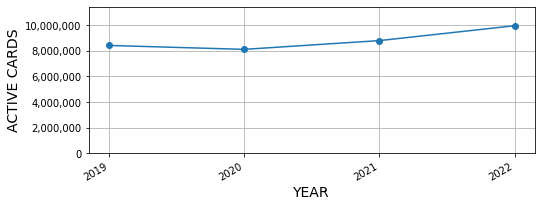

In [15]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

chart_revenue_year = [] 
for y in df_active_card_count_by_year.YEAR_NUMBER.tolist():
    chart_revenue_year.append(str(y))
    
fig, ax1 = plt.subplots(figsize=(8,3))
ax1.plot(chart_revenue_year,df_active_card_count_by_year['ACTIVE_CARD_COUNT'], marker='o')
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('ACTIVE CARDS', fontsize=14)
ax1.grid()
ax1.set_ylim(ymin=0, ymax=max_value*1.15)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
fig.autofmt_xdate()
plt.show()

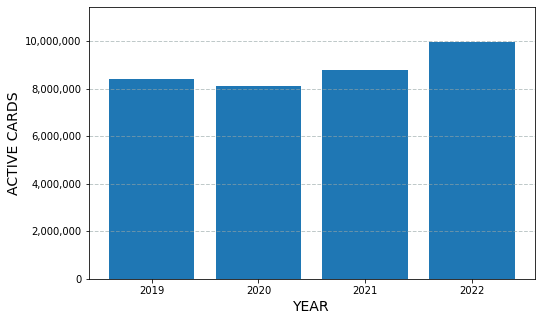

In [27]:
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

chart_revenue_year = [] 
for y in df_active_card_count_by_year.YEAR_NUMBER.tolist():
    chart_revenue_year.append(str(y))
    
fig, ax1 = plt.subplots(figsize=(8,5))
ax1.bar(chart_revenue_year, df_active_card_count_by_year['ACTIVE_CARD_COUNT'], width)
ax1.set_xlabel('YEAR', fontsize=14)
ax1.set_ylabel('ACTIVE CARDS', fontsize=14)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
ax1.set_ylim(ymin=0, ymax=max_value*1.15)
ax1.grid(color='#95a5a6', linestyle='--', linewidth=1, axis='y', alpha=0.6)
plt.show()

In [0]:
# Compute recipe outputs
# TODO: Write here your actual code that computes the outputs
# NB: DSS supports several kinds of APIs for reading and writing data. Please see doc.

#RETENTION_RATE_BY_GROUP_df = ... # Compute a Pandas dataframe to write into RETENTION_RATE_BY_GROUP

# Write recipe outputs
#RETENTION_RATE_BY_GROUP = dataiku.Dataset("RETENTION_RATE_BY_GROUP")
#RETENTION_RATE_BY_GROUP.write_with_schema(RETENTION_RATE_BY_GROUP_df)